In [14]:
%load_ext lab_black

In [1]:
from traffic.core import Traffic
t_clean = Traffic.from_file("Data/Go_Arounds_clean.parquet")
t = Traffic.from_file("Data/all_go_arounds.parquet")

In [2]:
t

,count
flight_id,
SWR1059_188,1809
UAE87_535,837
AUA78TQ_344,818
SWR194Z_628,715
FLJ602_415,706
OMA153_038,704
HBKPN_611,593
SWR963_410,531
None_322,524


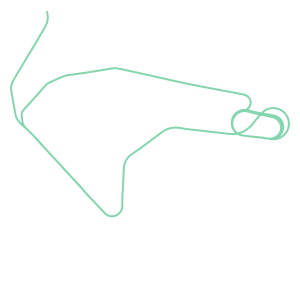

In [25]:
t["FLJ602_415"]

In [14]:
%load_ext lab_black

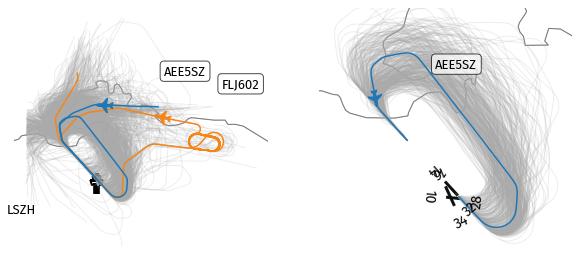

In [49]:
import matplotlib.pyplot as plt
from traffic.core.projection import CH1903p, EuroPP
from traffic.drawing import countries
from traffic.data import airports

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    for ax_ in ax:
        ax_.add_feature(countries())

    # ax[0].set_extent((8.1, 9, 47.37, 47.85))
    ax[1].set_extent((8.248, 8.825, 47.37, 47.75))

    t.plot(ax[0], alpha=0.2)

    t["FLJ602_415"].plot(ax[0], color="#f58518", lw=1.5)
    t["FLJ602_415"].at_ratio(0.8).plot(
        ax[0],
        color="#f58518",
        zorder=3,
        shift=dict(
            units="dots", x=60, y=30
        ),  # had to multiply by 3 because of increased dpi when saving
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    t["AEE5SZ_316"].plot(ax[0], color="#1f77b4", lw=1.5)
    t["AEE5SZ_316"].at_ratio(0.1).plot(
        ax[0],
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    t_clean.plot(ax[1], alpha=0.2)
    t_clean[0].plot(ax[1], color="#1f77b4", lw=1.5)
    t_clean[0].at_ratio(0.85).plot(
        ax[1],
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].point.plot(
        ax[0],
        text_kw=dict(fontname="Fira Sans", ha="right"),
        shift=dict(units="dots", x=-60, y=-30),
    )
    airports["LSZH"].plot(ax[1], footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax[1],
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )

In [50]:
fig.tight_layout()
fig.savefig("data_preparation.png", dpi=300)

In [42]:
def perp_to_ref(ref_traj_x, ref_traj_y, ref_traj_alt):

    """
    Inputs :
    ref_traj_x : array of x coordinates of the reference trajectory
    ref_traj_y : array of y coordinates of the reference trajectory
    ref_traj_alt : array of the altitude of the reference trajectory

    Outputs :
    perpendiculars : slope, intersect, and coordinates of the crossing point between perpendicular and ref traj
    """
    perpendiculars = []

    for i in range(len(ref_traj_x)):

        # Calculus of the perpendicular
        slope = (ref_traj_y[i] - ref_traj_y[i - 1]) / (
            ref_traj_x[i] - ref_traj_x[i - 1]
        )  # works too for i = 0
        p_slope = -1.0 / slope
        p_intersect = ref_traj_y[i] - p_slope * ref_traj_x[i]
        perpendiculars.append(
            (p_slope, p_intersect, ref_traj_x[i], ref_traj_y[i], ref_traj_alt[i])
        )

    return perpendiculars

In [50]:
def distances_to_line1(X0, Y0, m, k):
    dist_horiz = np.abs(k + m * X0 - Y0) / np.sqrt(1 + m ** 2)
    return dist_horiz


def sampling_from_ref1(perpendiculars, to_sample_x, to_sample_y):

    """
    Inputs :
    perpendiculars : output from perp_to_ref
    to_sample_x : array of x coordinates of the trajectory to sample
    to_sample_y : array of y coordinates of the trajectory to sample

    Outputs :
    argmin : index of sampled points within the traj to sample
    """

    argmin = []

    for i in range(len(perpendiculars)):

        p_slope = perpendiculars[i][0]
        p_intersect = perpendiculars[i][1]
        ref_traj_x = perpendiculars[i][2]
        ref_traj_y = perpendiculars[i][3]

        if len(argmin) == 0:
            remain_a = to_sample_x
            remain_b = to_sample_y
            offset_argmin = 0
            argmin.append(0)

        else:
            # On fait +1 pour éviter à avoir à répéter plusieur fois le même point

            remain_a = to_sample_x[(argmin[-1] + 1) : (argmin[-1] + 1) + 200]
            remain_b = to_sample_y[(argmin[-1] + 1) : (argmin[-1] + 1) + 200]
            offset_argmin = argmin[-1] + 1

            # distance to line in 2D
            dists_to_line = distances_to_line1(remain_a, remain_b, p_slope, p_intersect)

            # We take the closest points to perpendicular
            candidates = np.argsort(dists_to_line)[:10]
            # print("candidates :", candidates)

            # If we have some spurious points in the candidates
            if (candidates.max() - candidates.min()) > 20:
                # we take the point with the min distance to perpendicular among the closest to the ref point
                # in term of advancement in the trajectory
                right_point = candidates[candidates < candidates.mean()][0]

            # when we only have spurious points within the selected batch
            # That much because sometimes perpendiculars are crossing the traj before the previously selected point
            # So the algorithm detect the batch of closests points way too far from the ref
            # so we take the next one
            elif candidates.min() > 140:
                right_point = 0

            else:
                right_point = candidates[0]

            argmin.append(right_point + offset_argmin)
            # print("right point :", right_point)
            # print("argmin :", argmin[-1])
            # print("")

    return argmin

In [47]:
import pyproj
from traffic.core import Traffic

swiss = pyproj.Proj(init="EPSG:21781")

data = t.resample(200).compute_xy(projection=swiss).eval(desc="")

features = ["x", "y"]
raw_data = np.stack(list(f.data[features].values.ravel() for f in data))

/Users/xo/Library/miniconda3/envs/python39/lib/python3.9/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/xo/Library/miniconda3/envs/python39/lib/python3.9/site-packages/pyproj/crs/crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


  0%|          | 0/407 [00:00<?, ?it/s]

/Users/xo/Library/miniconda3/envs/python39/lib/python3.9/site-packages/traffic/core/flight.py:1259: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/Users/xo/Library/miniconda3/envs/python39/lib/python3.9/site-packages/traffic/core/flight.py:1259: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/Users/xo/Library/miniconda3/envs/python39/lib/python3.9/site-packages/traffic/core/flight.py:1259: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future

/Users/xo/Library/miniconda3/envs/python39/lib/python3.9/site-packages/traffic/core/flight.py:1259: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))


305


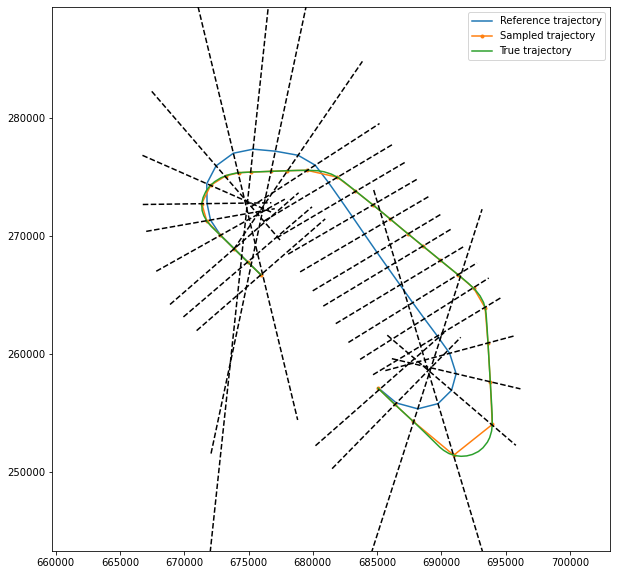

In [90]:
# take the shrotest traj (97)
nb_points = 30
x_centroid, y_centroid, alt_centroid = (
    data[97].resample(nb_points).data.x.values,
    data[97].resample(nb_points).data.y.values,
    data[97].resample(nb_points).data.altitude.values,
)

sel = np.random.randint(406)
# sel = "EWG5FW_205"
# sel = 213
print(sel)
# sel = 230
a = t[sel].resample("1s").compute_xy(swiss).data.x.values
b = t[sel].resample("1s").compute_xy(swiss).data.y.values
c = t[sel].resample("1s").data.altitude.values

perpendiculars = perp_to_ref(x_centroid, y_centroid, alt_centroid)
# argmin = sampling_from_ref(perpendiculars, a, b, c, lbda=0.8)
argmin = sampling_from_ref1(perpendiculars, a, b)


plt.figure(figsize=(10, 10))

plt.plot(x_centroid.T, y_centroid.T)
plt.plot(a[argmin], b[argmin], marker=".")
plt.plot(a, b)
plt.legend(["Reference trajectory", "Sampled trajectory", "True trajectory"])

for ele in perpendiculars:
    y1 = ele[0] * (ele[2] - 5000) + ele[1]
    y2 = ele[0] * (ele[2] + 5000) + ele[1]

    plt.plot(
        [(ele[2] - 5000), (ele[2] + 5000)],
        [y1, y2],
        color="black",
        linestyle="--",
    )

plt.xlim(x_centroid.min() - 12000, x_centroid.max() + 12000)
plt.ylim(y_centroid.min() - 12000, y_centroid.max() + 12000)

plt.show()

In [49]:
res = Traffic.from_file("Data/GA_resampled.parquet")

X = np.stack(list(f.data[features].values.ravel() for f in res))

230

/Users/xo/Library/miniconda3/envs/python39/lib/python3.9/site-packages/pyproj/crs/crs.py:1216: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/Users/xo/Library/miniconda3/envs/python39/lib/python3.9/site-packages/pyproj/crs/crs.py:1216: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/Users/xo/Library/miniconda3/envs/python39/lib/python3.9/site-packages/pyproj/crs/crs.py:1216: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-descr

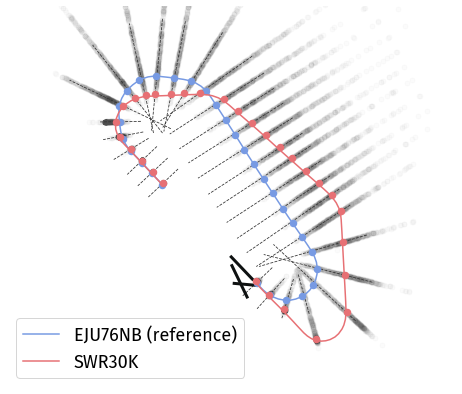

In [178]:
from cartes.crs import EPSG_21781

with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_21781()))
    # ax.add_feature(countries())
    elt, *_ = t[97].plot(ax, label=f"{t[97].callsign} (reference)")
    t[97].resample(30).plot(ax, marker=".", ms=15, lw=0, color=elt.get_color())

    elt, *_ = t[305].plot(ax, label=t[305].callsign)
    # t[305].resample(30).plot(ax, marker=".", lw=0, color=elt.get_color())

    ax.plot(a[argmin], b[argmin], marker=".", ms=15, lw=0, color=elt.get_color())

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    # airports["LSZH"].runways.plot(
    #    ax,
    #    runways=False,
    #    labels=True,
    #    shift=2000,
    #    text_kw=dict(fontname="Fira Sans", fontsize=14),
    # )

    for i, ele in enumerate(perpendiculars):
        # if i not in [3, 4, 7, 10, 13, 16, 20, 24]:
        # continue
        x1 = ele[2] - 5000
        x2 = ele[2] + 5000
        y1 = ele[0] * x1 + ele[1]
        y2 = ele[0] * x2 + ele[1]

        d = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

        xc, xd = (x1 + x2) / 2, (x2 - x1) / 2
        yc, yd = (y1 + y2) / 2, (y2 - y1) / 2

        scale = 11000 if 24 > i > 3 else 4000
        xd_ = xd * scale / d
        yd_ = yd * scale / d

        x1 = xc + xd_
        x2 = xc - xd_
        y1 = yc + yd_
        y2 = yc - yd_

        ax.plot([x1, x2], [y1, y2], color="0.2", linestyle="--", lw=0.8, zorder=1)

    for i in range(nb_points):
        ax.scatter(
            X[:, ::2][:, i].T,
            X[:, 1::2][:, i].T,
            marker=".",
            color="0.3",
            zorder=0,
            alpha=0.02,
        )

    ax.set_extent((8.248, 8.825, 47.37, 47.7))
    ax.legend(prop=dict(family="Fira Sans", style="normal", size=18))

In [179]:
fig.tight_layout()
fig.savefig("density.png")

In [2]:
# Generated data
X_raw = pd.read_pickle("Data/X_raw.pkl")
Real = pd.read_pickle("Data/distributions_along_lines.pkl")
Vines_samp = pd.read_pickle("Data/generated_vines_and_sampling.pkl")
Mvn_samp = pd.read_pickle("Data/generated_MVN_and_sampling.pkl")
Gm_samp = pd.read_pickle("Data/generated_GM_and_sampling.pkl")
Mvn_Wsamp = pd.read_pickle("Data/generated_MVN_without_sampling.pkl")
Gm_Wsamp = pd.read_pickle("Data/generated_GM_without_sampling.pkl")
Vines_Wsamp = pd.read_pickle("Data/generated_vines_without_sampling.pkl")

perpendiculars = pd.read_parquet("Data/Normals_sampling.parquet")
perpendiculars["angle"] = np.arctan(perpendiculars.m)

In [3]:
def reconstruct_trajs(df, sampled=True):
    n_gen = len(df)

    if sampled:
        gen_x = np.array(df) * np.array(
            [
                np.cos(perpendiculars.angle.values),
            ]
            * n_gen
        ) + np.array(
            [
                perpendiculars.x.values,
            ]
            * n_gen
        )

        calc_y = perpendiculars.m.values * gen_x + perpendiculars.p.values

    else:
        gen_x = np.array(df.iloc[:, ::2])
        calc_y = np.array(df.iloc[:, 1::2])

    return gen_x, calc_y

In [4]:
x, y = reconstruct_trajs(Vines_samp)

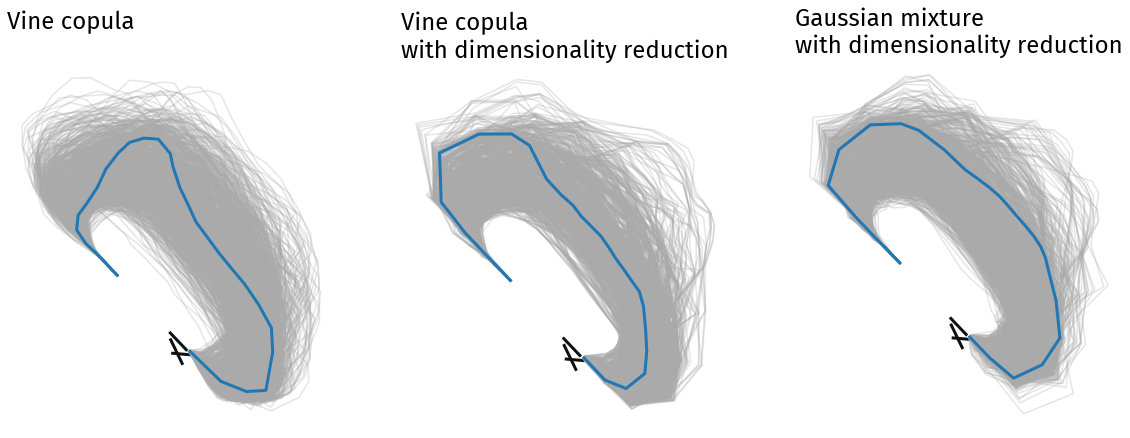

In [40]:
from matplotlib.collections import LineCollection
from cartes.crs import EPSG_21781
from traffic.data import airports

with plt.style.context("traffic"):
    fig, ax = plt.subplots(
        1, 3, figsize=(20, 9), subplot_kw=dict(projection=EPSG_21781())
    )
    for ax_ in ax:
        airports["LSZH"].plot(ax_, footprint=False, runways=dict(lw=1), labels=False)

    for data, sampled, ax_ in zip(
        [Vines_Wsamp, Vines_samp, Gm_samp], [False, True, True], ax
    ):
        gen_x, calc_y = reconstruct_trajs(data, sampled=sampled)
        for x, y in zip(gen_x, calc_y):
            ax_.plot(x, y, color="#aaa", alpha=0.3)
        ax_.plot(gen_x[100], calc_y[100], lw=3, color="#1f77b4")

    ax[0].set_title(
        "Vine copula\n", ha="left", fontname="Fira Sans", fontsize=24, loc="left"
    )
    ax[1].set_title(
        "Vine copula\nwith dimensionality reduction",
        ha="left",
        fontname="Fira Sans",
        fontsize=24,
        loc="left",
    )
    ax[2].set_title(
        "Gaussian mixture\nwith dimensionality reduction",
        ha="left",
        fontname="Fira Sans",
        fontsize=24,
        loc="left",
    )

In [42]:
from cartes.crs import PlateCarree

ax[2].get_extent(crs=PlateCarree())

(8.262706600348508, 8.84414060645136, 47.34578292114754, 47.7585011817003)

In [272]:
fig.tight_layout()
fig.savefig("generation.png")

In [1]:
# Signed curvature
def curvature(x, y):
    x_t = np.gradient(x)
    y_t = np.gradient(y)
    xx_t = np.gradient(x_t)
    yy_t = np.gradient(y_t)

    return (xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t) ** (3 / 2)


[<matplotlib.lines.Line2D object at 0x7f2371f3d520>]

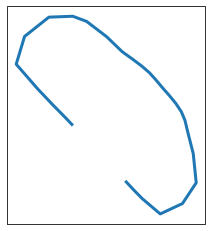

In [8]:
fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_21781()))
ax.plot(gen_x[100], calc_y[100], lw=3, color="#1f77b4")

<GeoAxesSubplot:xlabel='x', ylabel='y'>

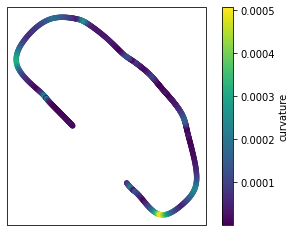

In [32]:
from scipy.interpolate import CubicSpline

fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_21781()))

x = list(range(0, 30))
y = np.vstack((gen_x[100], calc_y[100])).T
cs = CubicSpline(x, y)
xs = np.linspace(0, 29, 1000)

x, y = cs(xs).T
pd.DataFrame(dict(x=x, y=y, curvature= np.abs(curvature(x, y)))).plot.scatter(ax=ax,x='x', y='y', c='curvature', cmap="viridis")
#ax.plot(x, y, c=c)

In [34]:
%load_ext lab_black

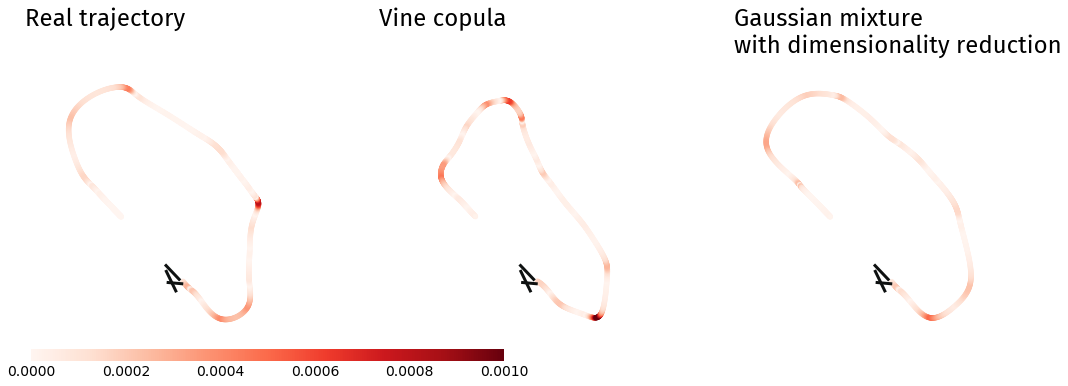

In [92]:
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from cartes.crs import EPSG_21781
from traffic.data import airports
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

with plt.style.context("traffic"):
    fig, ax = plt.subplots(
        1, 3, figsize=(18, 9), subplot_kw=dict(projection=EPSG_21781())
    )
    for ax_ in ax:
        airports["LSZH"].plot(ax_, footprint=False, runways=dict(lw=1), labels=False)
        ax_.set_extent((8.26, 8.84, 47.346, 47.758))

    for data, sampled, idx, ax_ in zip(
        [Real, Vines_Wsamp, Gm_samp], [True, False, True], [1, 100, 100], ax
    ):
        gen_x, calc_y = reconstruct_trajs(data, sampled=sampled)
        x = list(range(0, 30))

        y = np.vstack((gen_x[idx], calc_y[idx])).T
        cs = CubicSpline(x, y)
        xs = np.linspace(0, 29, 1000)

        x, y = cs(xs).T
        cax = pd.DataFrame(
            dict(x=x, y=y, curvature=np.abs(curvature(x, y)))
        ).plot.scatter(
            ax=ax_, x="x", y="y", c="curvature", cmap="Reds", vmax=1e-3, colorbar=False
        )

    ax[0].set_title(
        "Real trajectory\n", ha="left", fontname="Fira Sans", fontsize=24, loc="left"
    )
    ax[1].set_title(
        "Vine copula\n",
        ha="left",
        fontname="Fira Sans",
        fontsize=24,
        loc="left",
    )
    ax[2].set_title(
        "Gaussian mixture\nwith dimensionality reduction",
        ha="left",
        fontname="Fira Sans",
        fontsize=24,
        loc="left",
    )
    from matplotlib.cm import ScalarMappable

    cbaxes = inset_axes(ax[0], "160%", "4%", loc=3)
    cb = plt.colorbar(
        ScalarMappable(cmap="Reds", norm=Normalize(vmin=0, vmax=1e-3)),
        cax=cbaxes,
        orientation="horizontal",
    )

In [96]:
fig.tight_layout()
fig.savefig("curvature.png")